In [1]:
# analyze the relationship between the hyperparameters
# and the performance of the model on the test data
import signac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from copy import deepcopy
import pickle
import json

proj = signac.get_project()

In [2]:
# create dicts of average and standard deviation of each score for each 
# value of each hyperparameter on both test and train data
template = {'num_perceptrons': dict(), 'num_layers': dict(), 'alpha': dict()}

scores_avg = {'r2': deepcopy(template), 'rmse': deepcopy(template), 'mae': deepcopy(template)}
scores_std = {'r2': deepcopy(template), 'rmse': deepcopy(template), 'mae': deepcopy(template)}

for score in ['r2', 'rmse', 'mae']:
    for hyperparam in ['num_perceptrons', 'num_layers', 'alpha']:
        for val, group in proj.groupby(hyperparam):
            jobs = list(group)
            COF_test = np.array([job.doc['COF_{}_test'.format(score)] for job in jobs])
            COF_train = np.array([job.doc['COF_{}_train'.format(score)] for job in jobs])
            intercept_test = np.array([job.doc['intercept_{}_test'.format(score)] for job in jobs])
            intercept_train = np.array([job.doc['intercept_{}_train'.format(score)] for job in jobs])
            scores_avg[score][hyperparam][val] = {'COF_test': np.mean(COF_test),
                                                 'COF_train': np.mean(COF_train),
                                                 'intercept_test': np.mean(intercept_test),
                                                 'intercept_train': np.mean(intercept_train)
                                                }
            scores_std[score][hyperparam][val] = {'COF_test': np.std(COF_test),
                                                 'COF_train': np.std(COF_train),
                                                 'intercept_test': np.std(intercept_test),
                                                 'intercept_train': np.std(intercept_train)
                                                }

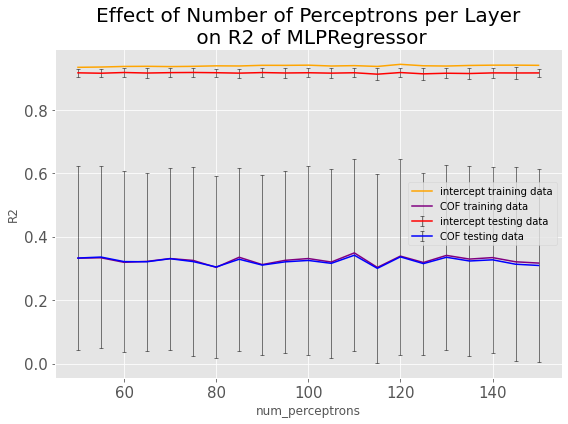

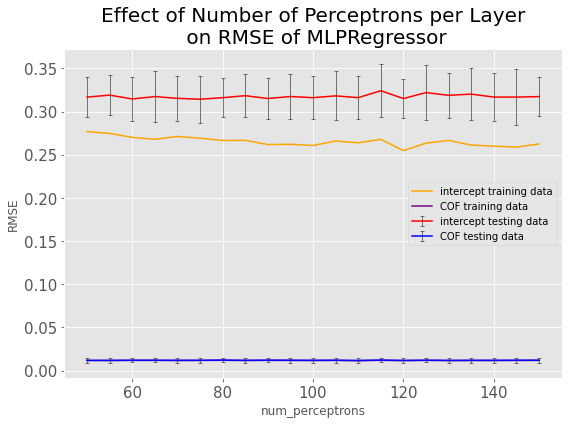

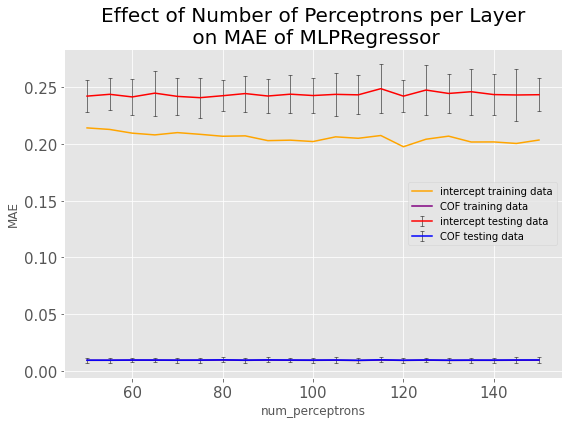

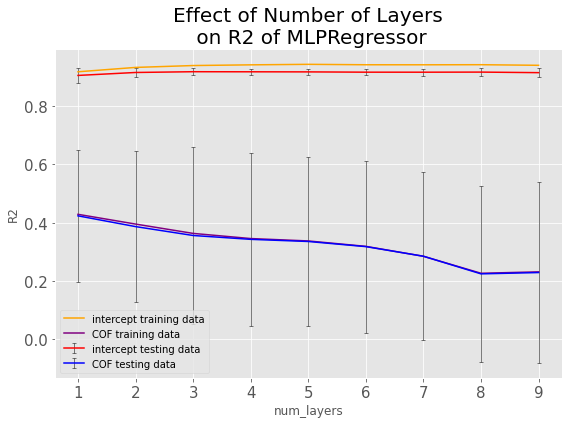

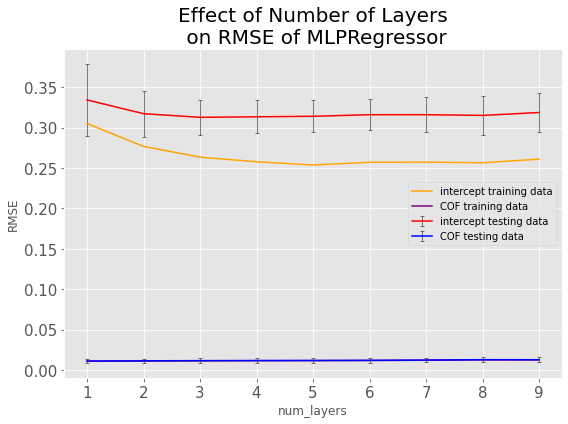

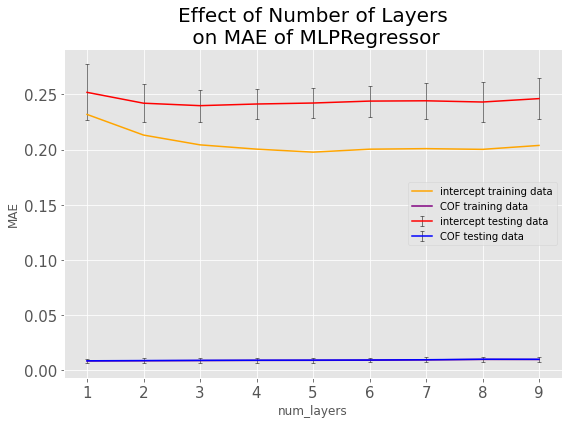

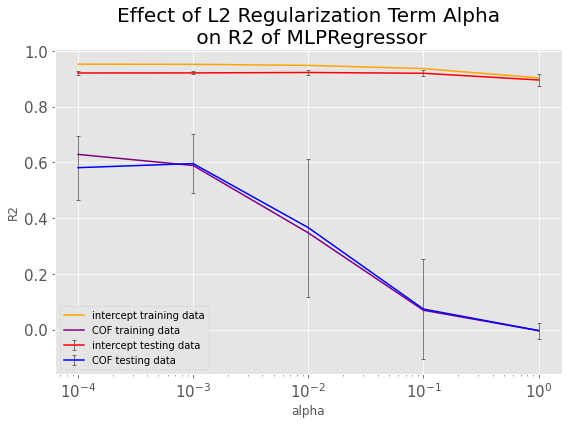

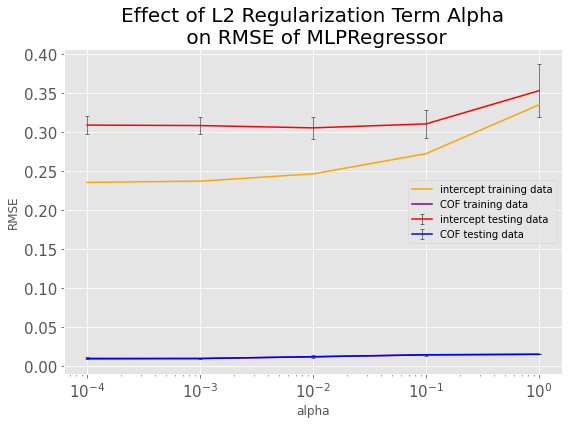

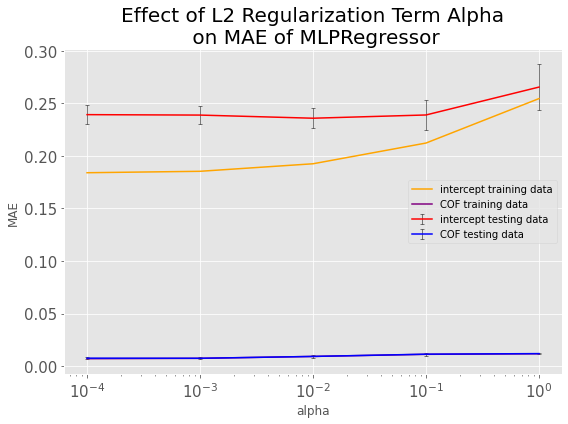

In [4]:
# plot the screened values of each parameter against vs avg r2, rmse, and mae for COF and intercept (test set)
plt.style.use('ggplot')

description = {'num_perceptrons': 'Number of Perceptrons per Layer',
               'num_layers': 'Number of Layers',
               'alpha': 'L2 Regularization Term Alpha'}

for i, hyperparam in enumerate(['num_perceptrons', 'num_layers', 'alpha']):
    for j, score in enumerate(['r2', 'rmse', 'mae']):
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        if hyperparam == 'alpha':
            ax.set_xscale('log')
        else:
            ax.set_xscale('linear')
        hyperparam_vals = np.array(list(scores_avg[score][hyperparam].keys()))

        COF_avg_test = np.array([scores_avg[score][hyperparam][v]['COF_test'] for v in hyperparam_vals])
        COF_std_test = np.array([scores_std[score][hyperparam][v]['COF_test'] for v in hyperparam_vals])
        int_avg_test = np.array([scores_avg[score][hyperparam][v]['intercept_test'] for v in hyperparam_vals])
        int_std_test = np.array([scores_std[score][hyperparam][v]['intercept_test'] for v in hyperparam_vals])
        
        COF_avg_train = np.array([scores_avg[score][hyperparam][v]['COF_train'] for v in hyperparam_vals])
        int_avg_train = np.array([scores_avg[score][hyperparam][v]['intercept_train'] for v in hyperparam_vals])
        
        markers, caps, bars = ax.errorbar(hyperparam_vals, int_avg_test, yerr=int_std_test, label='intercept testing data',
                    color='red', ecolor='black', elinewidth=1, capsize=2)
        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
        
        plt.plot(hyperparam_vals, int_avg_train, label='intercept training data', color='orange')
        
        markers, caps, bars = ax.errorbar(hyperparam_vals, COF_avg_test, yerr=COF_std_test, label='COF testing data',
                    color='blue', ecolor='black', elinewidth=1, capsize=2)
        
        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
        
        plt.plot(hyperparam_vals, COF_avg_train, label='COF training data', color='purple')
        
        plt.title('Effect of {}\n on {} of MLPRegressor'.format(description[hyperparam], score.upper()), fontsize=20)
        plt.xlabel(hyperparam)
        plt.ylabel(score.upper())
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend()
        plt.tight_layout()
        plt.savefig('../png-files/{}_{}.png'.format(hyperparam, score))

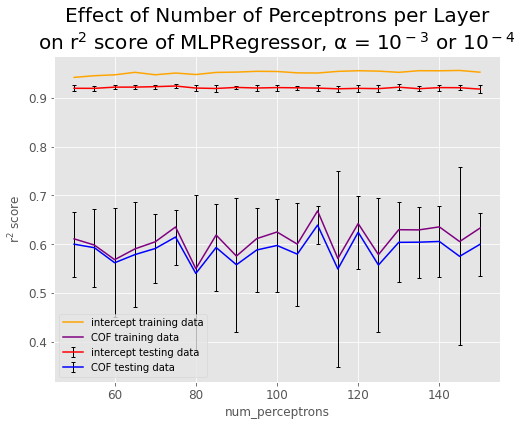

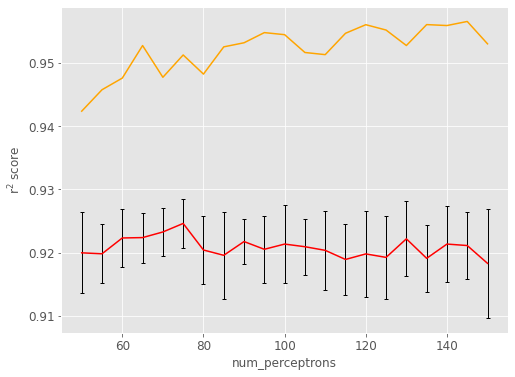

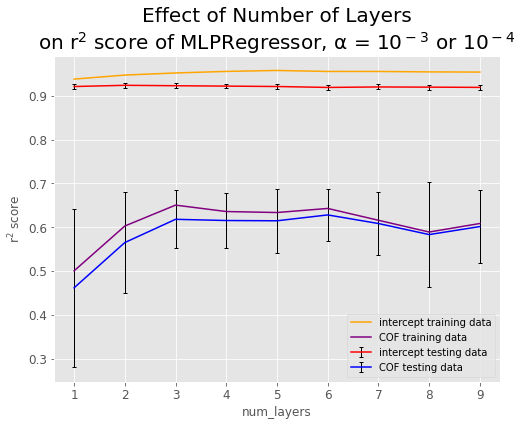

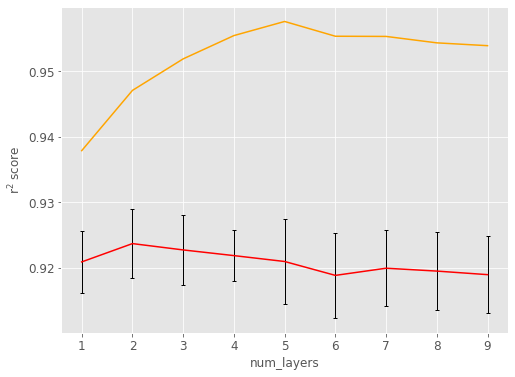

In [5]:
# plot average score as function of num_erceptrons and num_layers
# but only look at alpha = 10^-3 or 10^-4 and r^2
scores_avg_ = dict()
scores_std_ = dict()
for hyperparam in ['num_perceptrons', 'num_layers']:
    scores_avg_[hyperparam] = dict()
    scores_std_[hyperparam] = dict()
    for val, group in proj.groupby(hyperparam):
        jobs = list(group)
        COF_r2_test = np.array([job.doc['COF_r2_test'] for job in jobs if job.sp['alpha'] < 1e-2])
        COF_r2_train = np.array([job.doc['COF_r2_train'] for job in jobs if job.sp['alpha'] < 1e-2])
        intercept_r2_test = np.array([job.doc['intercept_r2_test'] for job in jobs if job.sp['alpha'] < 1e-2])
        intercept_r2_train = np.array([job.doc['intercept_r2_train'] for job in jobs if job.sp['alpha'] < 1e-2])
        scores_avg_[hyperparam][val] = {'COF_r2_test': np.mean(COF_r2_test),
                                       'COF_r2_train': np.mean(COF_r2_train),
                                       'intercept_r2_test': np.mean(intercept_r2_test),
                                       'intercept_r2_train': np.mean(intercept_r2_train)
                                      }
        scores_std_[hyperparam][val] = {'COF_r2_test': np.std(COF_r2_test),
                                       'COF_r2_train': np.std(COF_r2_train),
                                       'intercept_r2_test': np.std(intercept_r2_test),
                                       'intercept_r2_train': np.std(intercept_r2_train)
                                      }
for hyperparam in ['num_perceptrons', 'num_layers']:

    # plot COF and intercept on same plot
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_xscale('linear')

    hyperparam_vals = np.array(list(scores_avg_[hyperparam].keys()))

    COF_avg_test = np.array([scores_avg_[hyperparam][v]['COF_r2_test'] for v in hyperparam_vals])
    COF_std_test = np.array([scores_std_[hyperparam][v]['COF_r2_test'] for v in hyperparam_vals])
    int_avg_test = np.array([scores_avg_[hyperparam][v]['intercept_r2_test'] for v in hyperparam_vals])
    int_std_test = np.array([scores_std_[hyperparam][v]['intercept_r2_test'] for v in hyperparam_vals])
    
    COF_avg_train = np.array([scores_avg_[hyperparam][v]['COF_r2_train'] for v in hyperparam_vals])
    int_avg_train = np.array([scores_avg_[hyperparam][v]['intercept_r2_train'] for v in hyperparam_vals])

    plt.errorbar(hyperparam_vals, int_avg_test, yerr=int_std_test, label='intercept testing data',
                color='red', ecolor='black', elinewidth=1, capsize=2)
    plt.plot(hyperparam_vals, int_avg_train, label='intercept training data', color='orange')
    plt.errorbar(hyperparam_vals, COF_avg_test, yerr=COF_std_test, label='COF testing data',
                color='blue', ecolor='black', elinewidth=1, capsize=2)
    plt.plot(hyperparam_vals, COF_avg_train, label='COF training data', color='purple')
    
    plt.title('Effect of {}\non r$^2$ score of MLPRegressor, \u03B1 = 10$^-$$^3$ or 10$^-$$^4$'.format(description[hyperparam]), fontsize=20)
    plt.xlabel(hyperparam, )
    plt.ylabel('r$^2$ score')
    plt.legend()
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.savefig('../png-files/{}_optimal_alpha.png'.format(hyperparam))
    
    
    # plot intercept only to allow for bettee y-axis scale
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_xscale('linear')

    hyperparam_vals = np.array(list(scores_avg_[hyperparam].keys()))

    COF_avg_test = np.array([scores_avg_[hyperparam][v]['COF_r2_test'] for v in hyperparam_vals])
    COF_std_test = np.array([scores_std_[hyperparam][v]['COF_r2_test'] for v in hyperparam_vals])
    int_avg_test = np.array([scores_avg_[hyperparam][v]['intercept_r2_test'] for v in hyperparam_vals])
    int_std_test = np.array([scores_std_[hyperparam][v]['intercept_r2_test'] for v in hyperparam_vals])
    
    COF_avg_train = np.array([scores_avg_[hyperparam][v]['COF_r2_train'] for v in hyperparam_vals])
    int_avg_train = np.array([scores_avg_[hyperparam][v]['intercept_r2_train'] for v in hyperparam_vals])

    plt.errorbar(hyperparam_vals, int_avg_test, yerr=int_std_test, label='intercept testing data',
                color='red', ecolor='black', elinewidth=1, capsize=2)
    plt.plot(hyperparam_vals, int_avg_train, label='intercept training data', color='orange')
    plt.xlabel(hyperparam, )
    plt.ylabel('r$^2$ score')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.savefig('../png-files/{}_f0_optimal_alpha.png'.format(hyperparam))

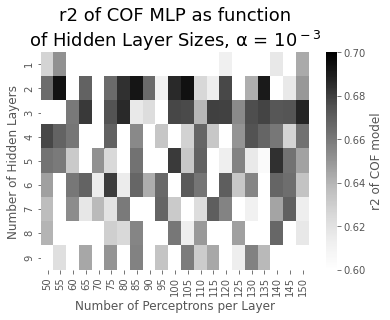

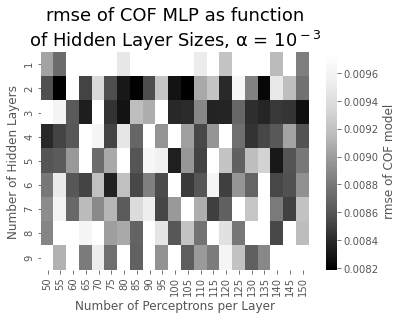

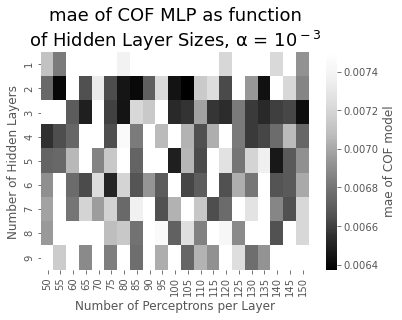

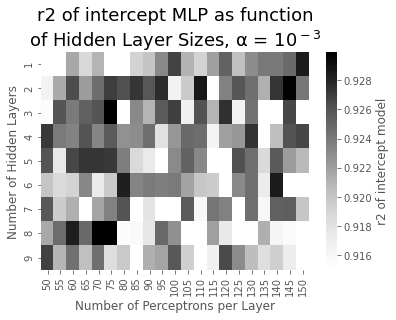

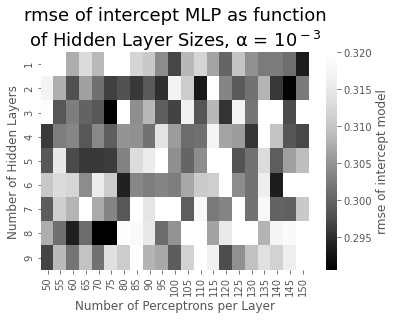

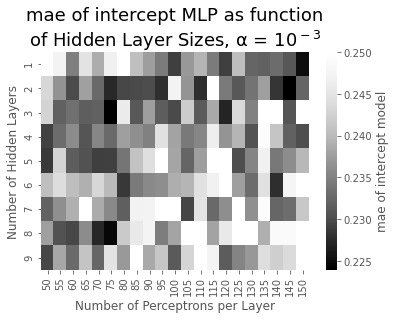

In [6]:
# heatmaps showing r2, rmse, and mae scores of COF and F0 models, alpha=10^-3
# x axis is num_perceptrons
# y axis is num_layers

heatmap_bounds = {'COF': {'r2': {'vmin': 0.6, 'vmax': 0.7},
                          'rmse': {'vmin': None, 'vmax': 0.00975},
                          'mae': {'vmin': None, 'vmax': 0.0075}},
                  'intercept': {'r2': {'vmin': 0.915, 'vmax': None},
                                'rmse': {'vmin': None, 'vmax': 0.32},
                                'mae': {'vmin': None, 'vmax': 0.25}}
                 }

for target in ['COF', 'intercept']:
    for score in ['r2', 'rmse', 'mae']:
        num_perceptrons_1d = list(range(50, 155, 5))
        num_layers_1d = list(range(1, 10))
        num_perceptrons_2d, num_layers_2d = np.meshgrid(num_perceptrons_1d, num_layers_1d)
        heatmap_vals = np.zeros(num_layers_2d.shape)
        for x in range(num_layers_2d.shape[0]):
            for y in range(num_layers_2d.shape[1]):
                job_cursor = proj.find_jobs({'num_perceptrons': num_perceptrons_2d[x, y],
                                             'num_layers': num_layers_2d[x, y],
                                             'alpha': 1e-3})
                job = list(job_cursor)[0]
                heatmap_vals[x, y] = job.doc['{}_{}_test'.format(target, score)]

        df = pd.DataFrame(heatmap_vals, index=num_layers_1d, columns=num_perceptrons_1d)
        plt.figure()
        sns.heatmap(df, vmin=heatmap_bounds[target][score]['vmin'],
                        vmax=heatmap_bounds[target][score]['vmax'],
                        cmap='Greys' if score=='r2' else 'Greys_r', cbar_kws={'label': '{} of {} model'.format(score, target)})
        plt.xlabel('Number of Perceptrons per Layer')
        plt.ylabel('Number of Hidden Layers')
        plt.title('{} of {} MLP as function\nof Hidden Layer Sizes, \u03B1 = 10$^-$$^3$'.format(
                  score, target), fontsize=18)
        plt.savefig('../png-files/heatmap_{}_{}'.format(target, score))

In [19]:
# Find which job statepoints have the highest R2 and lowest RMSE and MAE
# (they might be the same)

best_score_jobs = {'r2': dict(), 'rmse': dict(), 'mae': dict()}

best_score_jobs['r2']['COF'] = max([(j.doc['COF_r2_test'], j) for j in proj])
best_score_jobs['r2']['intercept'] = max([(j.doc['intercept_r2_test'], j) for j in proj])

best_score_jobs['rmse']['COF'] = min([(j.doc['COF_rmse_test'], j) for j in proj])
best_score_jobs['rmse']['intercept'] = min([(j.doc['intercept_rmse_test'], j) for j in proj])

best_score_jobs['mae']['COF'] = min([(j.doc['COF_mae_test'], j) for j in proj])
best_score_jobs['mae']['intercept'] = min([(j.doc['intercept_mae_test'], j) for j in proj])

In [34]:
# print info on highest scoring COF and intercept regressors
scorenames = ['r2', 'rmse', 'mae']

for scorename in scorenames:
    for target in ['COF', 'intercept']:
        score, job = best_score_jobs[scorename][target]
        print('{}est {} on test data for {} model:'.format(
              'High' if scorename == 'r2' else 'Low', scorename, target))
        print('Job id = {}'.format(job.id))
        print('{} on train data: {}'.format(scorename, score))
        print(' '.join(['hyperparameters:', str(job.sp)]))
        for other_scorename in scorenames:
            if other_scorename != scorename:
                other_score = job.doc['_'.join([target, other_scorename, 'test'])]
                print(other_scorename, '=', other_score)
        print('~'*20)
    print('~'*20)

Highest r2 on test data for COF model:
Job id = 29fad1179fe5eef78da6f8dfbd0c6d83
r2 on train data: 0.7046348341097204
hyperparameters: {'num_perceptrons': 125, 'num_layers': 9, 'alpha': 0.0001}
rmse = 0.0080439416956586
mae = 0.006297490674118761
~~~~~~~~~~~~~~~~~~~~
Highest r2 on test data for intercept model:
Job id = c6f41fc0ffd83255c1db9bf55cbf0a2a
r2 on train data: 0.932100577750341
hyperparameters: {'num_perceptrons': 145, 'num_layers': 4, 'alpha': 0.1}
rmse = 0.2861031425825795
mae = 0.2199000321737056
~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~
Lowest rmse on test data for COF model:
Job id = 29fad1179fe5eef78da6f8dfbd0c6d83
rmse on train data: 0.0080439416956586
hyperparameters: {'num_perceptrons': 125, 'num_layers': 9, 'alpha': 0.0001}
r2 = 0.7046348341097204
mae = 0.006297490674118761
~~~~~~~~~~~~~~~~~~~~
Lowest rmse on test data for intercept model:
Job id = c6f41fc0ffd83255c1db9bf55cbf0a2a
rmse on train data: 0.2861031425825795
hyperparameters: {'num_perceptrons': 145, 'num_

In [16]:
# import models and scalers
with open('../trained-models/COF_best.pickle', 'rb') as f:
    COF_model = pickle.load(f)
with open('../trained-models/COF_best_scaler.pickle', 'rb') as f:
    COF_scaler = pickle.load(f)
with open('../trained-models/intercept_best.pickle', 'rb') as f:
    intercept_model = pickle.load(f)
with open('../trained-models/intercept_best_scaler.pickle', 'rb') as f:
    intercept_scaler = pickle.load(f)

In [17]:
# import features used in best models
with open('../trained-models/COF_best_features.json', 'r') as f:
    COF_features = json.load(f)
with open('../trained-models/intercept_best_features.json', 'r') as f:
    intercept_features = json.load(f)

In [29]:
coefs = COF_model.coefs_
hiddens = coefs[0].T
final_mlp = coefs[1].flatten()

In [34]:
coefs = list(zip([dict(zip(COF_features, h)) for h in hiddens],
                     [['output mult:', m] for m in  final_mlp.flatten()], 
                     [['intercept:', i] for i in  COF_model.intercepts_[0]]))

In [35]:
coefs

[({'asphericity-min': -0.09710343290145736,
   'chi1n-min': 0.080378693348767,
   'eccentricity-min': -0.07774081503269838,
   'hbonds': 0.17310495125036884,
   'hbonds-a': -0.008891634836428762,
   'hbonds-b': 0.0793094407933705,
   'hk-alpha-min': 0.1371463223346337,
   'hk-kappa1-mean': 0.08697269056376267,
   'hk-kappa1-min': 0.09557730512104906,
   'hk-kappa3-min': 0.10214895992862838,
   'ipc-mean': -0.022673426468185782,
   'labuteASA-min': 0.014436938750314467,
   'logP-mean': 0.09096809475035225,
   'logP-min': 0.008231325665704989,
   'molwt-min': 0.01453050131725162,
   'npr1-mean': -0.04637115304207703,
   'npr1-min': 0.12994519525696818,
   'npr2-mean': 0.10901884336563343,
   'npr2-min': -0.07723823813766452,
   'pct-aromatic-mean': 0.06074163770960342,
   'pct-aromatic-min': -0.07676495902653552,
   'pmi1-min': 0.04310387960633123,
   'pmi2-mean': -0.0545001469505239,
   'rbonds-mean': -0.05863879614301809,
   'rbonds-min': 0.08424788199417135,
   'rg-mean': -0.074845755